In [4]:
%%capture
#@markdown # YOLOv8 dataset training
!python -m pip install onnx
!python -m pip install abraia
!python -m pip install ultralytics

import os
if not os.getenv('ABRAIA_ID') and not os.getenv('ABRAIA_KEY'):
    abraia_id = ''  #@param {type: "string"}
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_ID=$abraia_id
    %env ABRAIA_KEY=$abraia_key

from abraia import Abraia

multiple = Abraia()

In [5]:
import json
import itertools
from PIL import Image
from tqdm.contrib.concurrent import process_map
from sklearn.model_selection import train_test_split


def download_file(path, folder):
    dest = os.path.join(folder, 'images', os.path.basename(path))
    if not os.path.exists(dest):
        multiple.download_file(path, dest)
    return dest


def save_annotation(path, annotation, folder):
    im = Image.open(os.path.join(folder, 'images', os.path.basename(path)))
    cords, bbox = annotation['polygon'], annotation['box']
    # Convert polygon or box to yolo format
    if task == 'segmentation':
        label_line = '0 ' + ' '.join([f"{cord[0] / im.width} {cord[1] / im.height}" for cord in cords])
    else:
        label_line = f"0 {(bbox[0] + bbox[2] / 2) / im.width} {(bbox[1] + bbox[3] / 2) / im.height} {bbox[2] / im.width} {bbox[3] / im.height}"
    label_path = os.path.join(folder, 'labels',  f"{os.path.splitext(os.path.basename(path))[0]}.txt")
    with open(label_path, 'w') as f:
        f.write(label_line)


def save_data(paths, annotations, folder):
    os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
    process_map(download_file, paths, itertools.repeat(folder), max_workers=5)
    os.makedirs(os.path.join(folder, 'labels'), exist_ok=True)
    for path, annotation in zip(paths, annotations):
        label_line = save_annotation(path, annotation, folder)


def save_config(path, class_names):
    yaml_content = f'''
    train: {os.path.join(os.getcwd(), dataset, 'train/images')}
    val: {os.path.join(os.getcwd(), dataset, 'val/images')}
    test: {os.path.join(os.getcwd(), dataset, 'test/images')}
    names: {class_names}
    '''
    with open(path, 'w') as f:
        f.write(yaml_content)


def create_dataset(dataset):
    annotations = json.loads(multiple.load_file(f"{dataset}/annotations.json"))
    paths = [f"{dataset}/{annotation['filename']}" for annotation in annotations]
    class_names = list(set([annotation['label'] for annotation in annotations]))
    train_paths, test_paths, train_annotations, test_annotations = train_test_split(paths, annotations, test_size=0.3)
    val_paths, test_paths, val_annotations, test_annotations = train_test_split(test_paths, test_annotations, test_size=0.5)
    data_paths = {'train': train_paths, 'val': val_paths, 'test': test_paths}
    data_annotations = {'train': train_annotations, 'val': val_annotations, 'test': test_annotations}
    for x in ['train', 'val', 'test']:
        save_data(data_paths[x], data_annotations[x], f"{dataset}/{x}")
    save_config(os.path.join(dataset, 'data.yaml'), class_names)
    return class_names


task = 'detection'
dataset = 'circles'

classes = create_dataset(dataset)
print(classes)

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
from ultralytics import YOLO

model_name = 'yolov8n-seg' if task == 'segmentation' else 'yolov8n'

model = YOLO(f"{model_name}.pt")

results = model.train(batch=8, device="cpu", data=f"{dataset}/data.yaml", epochs=7, imgsz=120)

100%|██████████| 6.23M/6.23M [00:00<00:00, 55.5MB/s]


Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=circles/data.yaml, epochs=7, time=None, patience=100, batch=8, imgsz=120, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 21.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/circles/train/labels... 183 images, 0 backgrounds, 0 corrupt: 100%|██████████| 183/183 [00:00<00:00, 2038.92it/s]

train: New cache created: /content/circles/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/circles/val/labels... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<00:00, 2369.59it/s]

val: New cache created: /content/circles/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 7 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/7         0G     0.8369      2.413     0.9201         13        128: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all         57         57     0.0232          1       0.93      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/7         0G     0.6735     0.8102     0.8708         11        128: 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all         57         57          1      0.984      0.995      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/7         0G     0.6573     0.6757     0.8933          9        128: 100%|██████████| 23/23 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all         57         57      0.993          1      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/7         0G     0.6058     0.6284     0.8633         15        128: 100%|██████████| 23/23 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all         57         57      0.999          1      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/7         0G     0.6083     0.6188     0.8991         15        128: 100%|██████████| 23/23 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all         57         57      0.999          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/7         0G     0.5428     0.6023     0.8639          7        128: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all         57         57      0.999          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/7         0G     0.5338     0.6339     0.8653         16        128: 100%|██████████| 23/23 [00:07<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         57         57      0.999          1      0.995      0.918



7 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


                   all         57         57      0.999          1      0.995      0.926
Speed: 0.8ms preprocess, 27.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train


In [7]:
model_src = model.export(format="onnx")

multiple.upload_file(model_src, f"{dataset}/{model_name}.onnx")
multiple.save_json(f"{dataset}/{model_name}.json", {'inputShape': [1, 3, 128, 128], 'classes': classes})

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 128, 128) BCHW and output shape(s) (1, 5, 336) (5.9 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 0.8s, saved as 'runs/detect/train/weights/best.onnx' (11.5 MB)

Export complete (2.2s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=128  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=128 data=circles/data.yaml  
Visualize:       https://netron.app


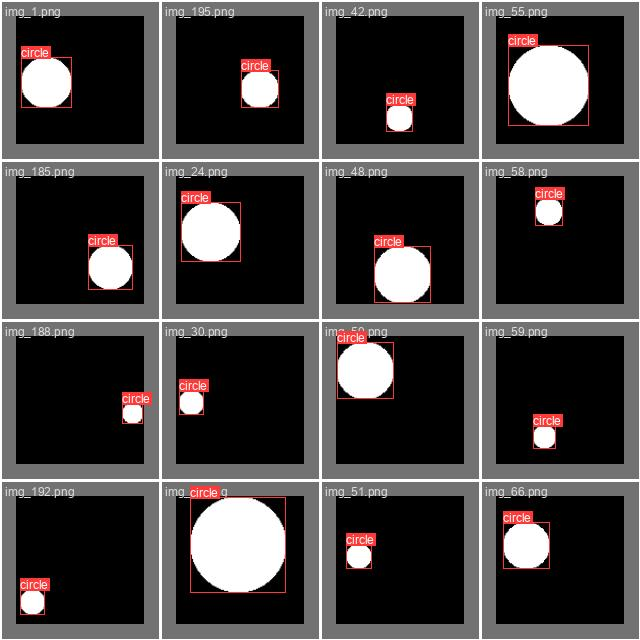

In [8]:
from IPython.display import Image as show_image

folder = 'segment' if task == 'segmentation' else 'detect'
show_image(filename=f"runs/{folder}/train/val_batch0_labels.jpg")

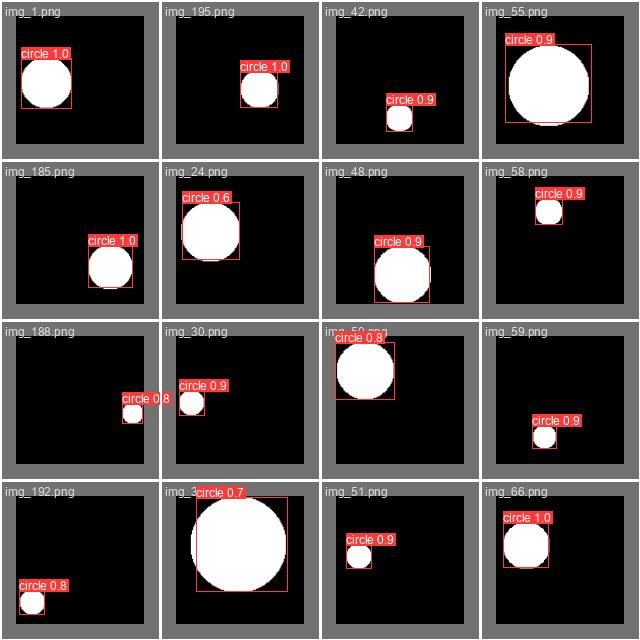

In [9]:
show_image(filename=f"runs/{folder}/train/val_batch0_pred.jpg")

In [13]:
import glob

my_model = YOLO(f"runs/{folder}/train/weights/best.pt")

src = glob.glob(f"{dataset}/test/images/*.png")[0]
results = list(my_model(src, conf=0.128))
result = results[0]


image 1/1 /content/circles/test/images/img_136.png: 128x128 1 circle, 32.6ms
Speed: 2.1ms preprocess, 32.6ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 128)


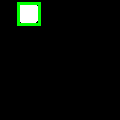

In [14]:
from PIL import ImageDraw

img = Image.open(src).convert('RGB')
draw = ImageDraw.Draw(img)
for box in result.boxes.data:
    x1, y1, x2, y2, class_id, prob = box
    draw.rectangle((x1, y1, x2, y2), None, "#00ff00", width=3)
if task == 'segmentation':
    polygon = result.masks.xy[0]
    draw.polygon(polygon, outline="#ffff00", width=2)
img